## Pure Lightgbm approach forecast 5 days return kurtosis

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [36]:
# 1. read eth price
eth = pd.read_csv("ETH_price.csv")
eth['date'] = pd.to_datetime(eth['Date(UTC)'])  
eth = eth[['date', 'Value']].rename(columns={'Value': 'ETH_close'})

# 2. read vix
vix = pd.read_csv("vix-daily.csv")
vix['date'] = pd.to_datetime(vix['DATE'])       
vix = vix[['date', 'CLOSE']].rename(columns={'CLOSE': 'VIX_close'})

# 3. read BTC + SP500 + GOLD + DXY
mkt = pd.read_csv("btc_full_sp500_gold_dxy_close_2017_onward.csv")
mkt['date'] = pd.to_datetime(mkt['date'])

# 4. aggregate by date
df = mkt.merge(eth, on='date', how='inner').merge(vix, on='date', how='left')

df = df.sort_values('date').reset_index(drop=True)
print(df.head())
print(df.tail())


        date     BTC_open     BTC_high      BTC_low    BTC_close   BTC_volume  \
0 2017-01-03  1021.599976  1044.079956  1021.599976  1043.839966  185168000.0   
1 2017-01-04  1044.400024  1159.420044  1044.400024  1154.729980  344945984.0   
2 2017-01-05  1156.729980  1191.099976   910.416992  1013.380005  510199008.0   
3 2017-01-06  1014.239990  1046.810059   883.943970   902.200989  351876000.0   
4 2017-01-09   913.244019   913.685974   879.807007   902.828003  141876992.0   

   SP500_close   GOLD_close   DXY_close  ETH_close  VIX_close  
0  2257.830078  1160.400024  103.209999       9.60      12.85  
1  2270.750000  1163.800049  102.699997      10.88      11.85  
2  2269.000000  1179.699951  101.519997      10.20      11.67  
3  2276.979980  1171.900024  102.220001      10.07      11.32  
4  2268.899902  1183.500000  101.930000      10.20      11.56  
           date       BTC_open       BTC_high        BTC_low      BTC_close  \
2225 2025-11-10  104723.773438  106564.695312  104

In [37]:
window = 5

# daily ETH return
df['eth_ret'] = df['ETH_close'].pct_change()

# ============================
# Downside volatility features
# ============================

# negative returns only (positive returns set to 0)
df['eth_ret_neg'] = df['eth_ret'].clip(upper=0)

# past 5-day downside realized vol (feature)
df['eth_down_vol_5d_past'] = df['eth_ret_neg'].rolling(window).std()
df['eth_down_vol_5d_past'] = df['eth_down_vol_5d_past'] * np.sqrt(252 / window)

# next 5-day downside realized vol (target)
df['eth_down_vol_5d_next'] = df['eth_ret_neg'].rolling(window).std().shift(-1)
df['eth_down_vol_5d_next'] = df['eth_down_vol_5d_next'] * np.sqrt(252 / window)

# ============================
# Total volatility features
# ============================

# past 5 days realized vol (total volatility)
df['eth_vol_5d_past'] = df['eth_ret'].rolling(window).std()
df['eth_vol_5d_past'] = df['eth_vol_5d_past'] * np.sqrt(252 / window)

# next 5 days realized vol (total volatility)
df['eth_vol_5d_next'] = df['eth_ret'].rolling(window).std().shift(-1)
df['eth_vol_5d_next'] = df['eth_vol_5d_next'] * np.sqrt(252 / window)


# past 5-day realized kurtosis (Fisher-style, excess kurtosis)
df['eth_kurt_5d_past'] = df['eth_ret'].rolling(window).kurt()

# next 5-day realized kurtosis (target for RM kurtosis model)
df['eth_kurt_5d_next'] = df['eth_ret'].rolling(window).kurt().shift(-1)


# ============================
# Return-based features
# ============================

# same-day returns for all assets
df['eth_ret_today']   = df['ETH_close'].pct_change()
df['btc_ret_today']   = df['BTC_close'].pct_change()
df['sp500_ret_today'] = df['SP500_close'].pct_change()
df['gold_ret_today']  = df['GOLD_close'].pct_change()
df['dxy_ret_today']   = df['DXY_close'].pct_change()
df['vix_ret_today']   = df['VIX_close'].pct_change()

# lag-1 returns (you may shift by 1 if needed)
df['eth_ret_1d_lag1']   = df['eth_ret_today']
df['btc_ret_1d_lag1']   = df['btc_ret_today']
df['sp500_ret_1d_lag1'] = df['sp500_ret_today']
df['gold_ret_1d_lag1']  = df['gold_ret_today']
df['dxy_ret_1d_lag1']   = df['dxy_ret_today']
df['vix_ret_1d_lag1']   = df['vix_ret_today']

# keep some level factor (VIX level)
df['VIX_level'] = df['VIX_close']

# drop NA created by rolling/shift
df_model = df.dropna().copy()


In [38]:
# cut the data
train_end = "2023-12-31"
val_end   = "2024-12-31"

train = df_model[df_model['date'] <= train_end]
val   = df_model[(df_model['date'] > train_end) & (df_model['date'] <= val_end)]
test  = df_model[df_model['date'] > val_end]

# feature list
features = [
    # ----------------------------
    # 1. Level / price information
    # ----------------------------
    'BTC_open', 'BTC_high', 'BTC_low', 'BTC_close', 'BTC_volume',
    'SP500_close', 'GOLD_close', 'DXY_close',
    'ETH_close', 'VIX_close',     # key market sentiment proxy

    # ----------------------------
    # 2. Return-based signals
    #    (same-day returns, capturing shocks)
    # ----------------------------
    'eth_ret_today', 'btc_ret_today', 'sp500_ret_today',
    'gold_ret_today', 'dxy_ret_today', 'vix_ret_today',

    # ----------------------------
    # 3. Lagged returns
    #    (one-step memory of market shocks)
    # ----------------------------
    'eth_ret_1d_lag1', 'btc_ret_1d_lag1', 'sp500_ret_1d_lag1',
    'gold_ret_1d_lag1', 'dxy_ret_1d_lag1', 'vix_ret_1d_lag1',

    # ----------------------------
    # 4. Volatility features
    # ----------------------------
    'eth_vol_5d_past',        # total realized volatility (baseline)
    'eth_down_vol_5d_past',   # downside realized volatility (critical feature)
    'eth_kurt_5d_past'
]


target = 'eth_kurt_5d_next'

X_train, y_train = train[features], train[target]
X_val,   y_val   = val[features],   val[target]
X_test,  y_test  = test[features],  test[target]

print("Train size:", X_train.shape, "Val size:", X_val.shape, "Test size:", X_test.shape)


Train size: (1754, 25) Val size: (252, 25) Test size: (218, 25)


In [39]:
params = {
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'n_jobs': -1,
    'random_state': 42,
}

model = lgb.LGBMRegressor(**params)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[lgb.early_stopping(50, verbose=False)]
)

pred_val = model.predict(X_val)
pred_test = model.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 1754, number of used features: 25
[LightGBM] [Info] Start training from score 0.445530


In [40]:
# test model
mse_val = mean_squared_error(y_val, pred_val)
mse_test = mean_squared_error(y_test, pred_test)
mse = mean_squared_error(y_test, pred_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, pred_test)
r2 = r2_score(y_test, pred_test)

print("MSE :", mse)
print("RMSE:", rmse)
print("MAE :", mae)
print("R^2 :", r2)

pred_val = model.predict(X_val)
pred_test = model.predict(X_test)

print("Baseline LGBM - Val MSE:", mse_val)
print("Baseline LGBM - Test MSE:", mse_test)

corr = np.corrcoef(y_test, pred_test)[0, 1]
print("Correlation:", corr)


MSE : 3.037250056091342
RMSE: 1.7427707984962744
MAE : 1.4131959879255163
R^2 : 0.20516279560554218
Baseline LGBM - Val MSE: 3.2202488662072866
Baseline LGBM - Test MSE: 3.037250056091342
Correlation: 0.4665432821136965


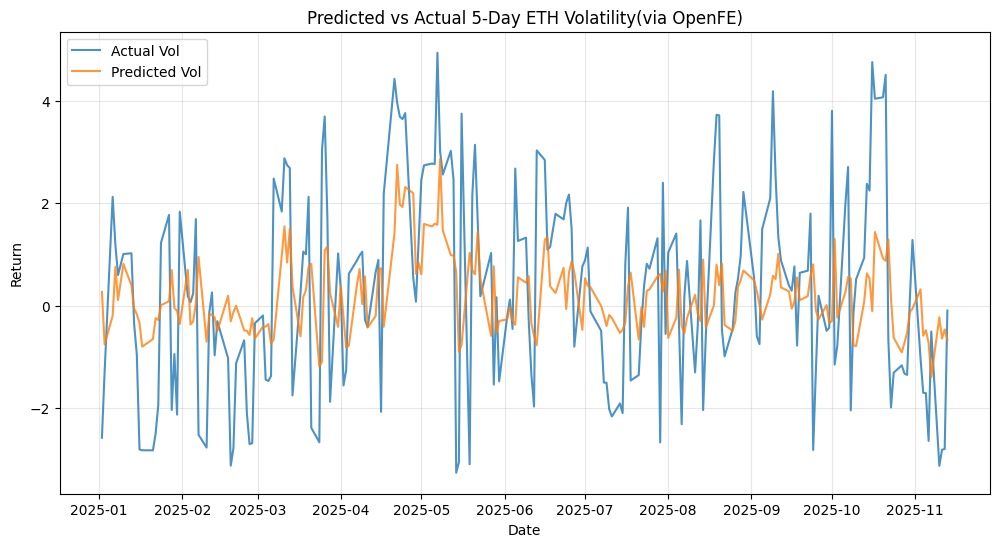

In [41]:
# build a DataFrame for plotting
plot_df = pd.DataFrame({
    'date': test['date'].values,   # time index
    'actual': y_test.values,       # actual future ETH return
    'predicted': pred_test         # model prediction
})

# set date as index
plot_df = plot_df.set_index('date')

# plot
plt.figure(figsize=(12,6))

# plot actual returns
plt.plot(plot_df.index, plot_df['actual'], label='Actual Vol', alpha=0.8)

# plot predicted returns
plt.plot(plot_df.index, plot_df['predicted'], label='Predicted Vol', alpha=0.8)

# styling
plt.title("Predicted vs Actual 5-Day ETH Volatility(via OpenFE)")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()



In [42]:
# ===== Naive baseline: down_vol_{t+1} = down_vol_t =====
y_test_down = test['eth_kurt_5d_next']
y_pred_naive_down = test['eth_kurt_5d_past']  # directly use past 5-day downside vol

mse_naive_d  = mean_squared_error(y_test_down, y_pred_naive_down)
rmse_naive_d = np.sqrt(mse_naive_d)
mae_naive_d  = mean_absolute_error(y_test_down, y_pred_naive_down)
r2_naive_d   = r2_score(y_test_down, y_pred_naive_down)

print("=== Naive Downside Vol Baseline (down_vol_{t+1} = down_vol_t) ===")
print(f"Test RMSE: {rmse_naive_d}")
print(f"Test MAE : {mae_naive_d}")
print(f"Test R^2 : {r2_naive_d}")



=== Naive Downside Vol Baseline (down_vol_{t+1} = down_vol_t) ===
Test RMSE: 2.0219247753590888
Test MAE : 1.4058896057562673
Test R^2 : -0.0698616646858301
